### Installation of Essential Libraries

In [ ]:
%pip install geopandas osmnx pysal splot matplotlib seaborn openrouteservice contextily rioxarray shapely scipy numpy pandas folium statsmodels

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import warnings

warnings.filterwarnings("ignore")

## Importing libraries

In [5]:
import geopandas as gpd
import osmnx
from pysal.explore import esda
from splot.esda import lisa_cluster,moran_scatterplot
from pysal.lib import weights 
from funcs import *

# Data Loading

In [6]:
# Specify the path to the GeoJSON file
file_path = "Dataset/2009_2020CrimeData.geojson"

# Read the GeoJSON file into a GeoDataFrame
gdf = gpd.read_file(file_path)
gdf = gdf.to_crs(epsg=4326)

gdf.head()

IDCol Report_Number                    Report_Date Day_Occurred  \
0  320197     203581105  Wed, 23 Dec 2020 00:00:00 GMT    Wednesday   
1  320198     203581144  Wed, 23 Dec 2020 00:00:00 GMT    Wednesday   
2  320199     203581174  Wed, 23 Dec 2020 00:00:00 GMT     Saturday   
3  320200     203581238  Wed, 23 Dec 2020 00:00:00 GMT    Wednesday   
4  320201     203581247  Wed, 23 Dec 2020 00:00:00 GMT    Wednesday   

   Day_Number  Occur_Date Occur_Time Possible_Date Possible_Time  Beat  ...  \
0           4  12/23/2020      10:00    12/23/2020         16:45   410  ...   
1           4  12/23/2020      17:16    12/23/2020         17:30   505  ...   
2           7  12/19/2020      21:50    12/19/2020         22:30   211  ...   
3           4  12/23/2020      18:05    12/23/2020         18:09   206  ...   
4           4  12/23/2020      18:12          NULL          NULL   204  ...   

                 Location Apartment_Number            Crime_Type NIBRS_Code  \
0  2400 CAMPBELLTON RD SW             NULL              BURGLARY        220   
1   736 W PEACHTREE ST NW             NULL  LARCENY-FROM VEHICLE        23F   
2     2399 PIEDMONT RD NE             NULL  LARCENY-FROM VEHICLE        23F   
3     339 BUCKHEAD AVE NE             NULL            AUTO THEFT        240   
4  1801 HOWELL MILL RD NW             NULL   LARCENY-NON VEHICLE        23C   

        Neighborhood NPU  Longitude   Latitude  ObjectId  \
0   Campbellton Road   R -84.466012  33.702732         1   
1            Midtown   E -84.387771  33.774764         2   
2  Lindbergh/Morosgo   B -84.366938  33.819892         3   
3   Buckhead Village   B -84.376506  33.837935         4   
4      Berkeley Park   D -84.412846  33.804230         5   

                     geometry  
0  POINT (-84.46601 33.70273)  
1  POINT (-84.38777 33.77476)  
2  POINT (-84.36694 33.81989)  
3  POINT (-84.37651 33.83793)  
4  POINT (-84.41285 33.80423)  

[5 rows x 21 columns]

In [7]:
# Define the bounding box of the study area
atl = osmnx.geocode_to_gdf("Atlanta, Georgia, USA")
atl_bbox = atl.total_bounds  

# Define the file paths for each year's population data
pop_file_paths = {
    2016: "Dataset/usa_pd_2016_1km.tif",
    2017: "Dataset/usa_pd_2017_1km.tif",
    2018: "Dataset/usa_pd_2018_1km.tif",
    2019: "Dataset/usa_pd_2019_1km.tif",
    2020: "Dataset/usa_pd_2020_1km.tif"
}

# List of years for which population data is to be loaded
years = [2016, 2017, 2018, 2019, 2020]

# Load population data
pops = load_population_data(years, pop_file_paths, atl_bbox)
pops[2020]

<xarray.DataArray (band: 1, y: 30, x: 32)>
[960 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -84.55 -84.54 -84.53 -84.52 ... -84.31 -84.3 -84.29
  * y            (y) float64 33.89 33.88 33.87 33.86 ... 33.67 33.66 33.65 33.65
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  67025.2890625
    STATISTICS_MEAN:     32.19958094991
    STATISTICS_MINIMUM:  0
    STATISTICS_STDDEV:   271.89026458051
    scale_factor:        1.0
    add_offset:          0.0
    _FillValue:          -99999.0

# Data Preprocessing

In [8]:
original_gdf = filter_crime_data(gdf)
# Create a new GeoDataFrames with only the selected columns
gdf_with_date = original_gdf[['Occur_Date', 'geometry']].copy()
gdf_with_time = original_gdf[['Occur_Time','geometry']].copy()
crime_gdf = original_gdf[['geometry']].copy()

In [9]:
gdf_with_date = preprocess_date_column(gdf_with_date)

In [10]:
gdf_with_time = preprocess_time_column(gdf_with_time)

# Basic Analysis

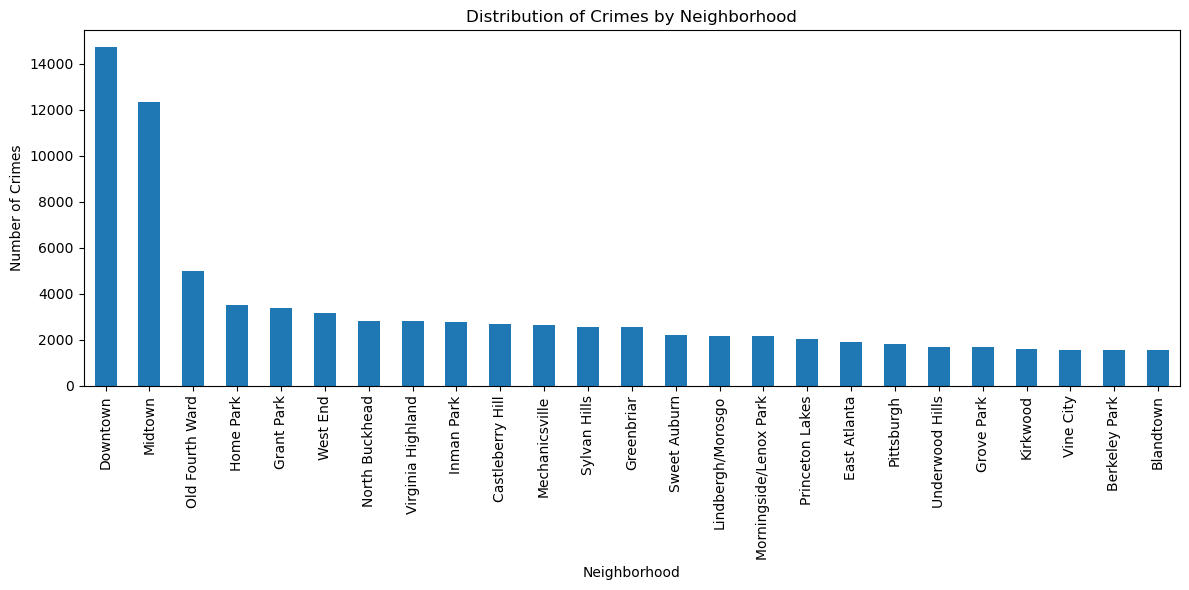

In [9]:
plot_crime_distribution_by_neighborhood(original_gdf)

It can be observed that Downtown and Midtown are the most crime affected neighborhoods in the dataset.

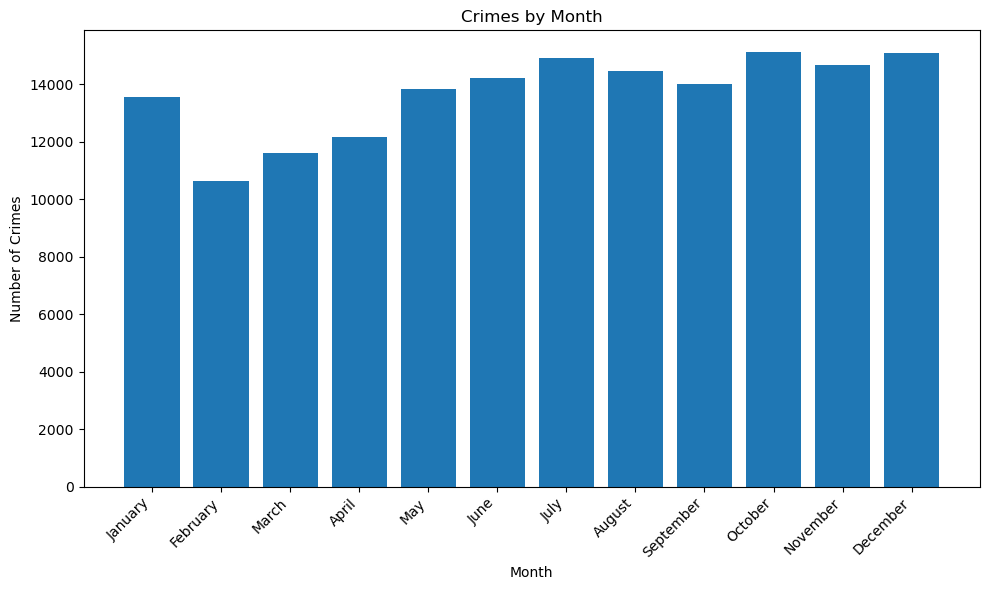

In [10]:
plot_crime_months_distribution(gdf_with_date)

It can be observed that except for February-April, the number of crimes is relatively same throughout the years. However, in the months of February-April, the number of crimes is relatively lower.

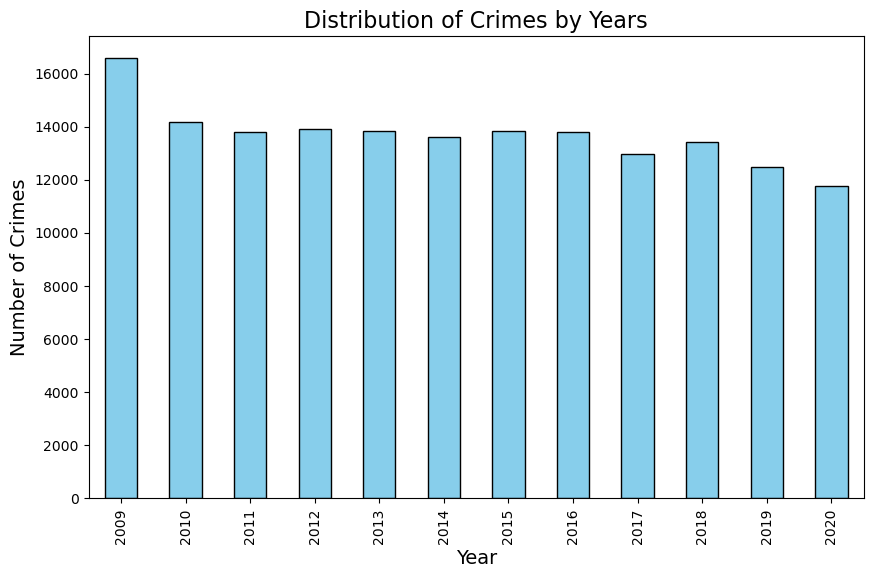

In [13]:
plot_crime_distribution_by_years(gdf_with_date)

It can be observed that the number of crimes has been decreasing over the last few years. This could be due to various reasons such as increased police presence, improved security measures, or changes in the socio-economic conditions of the city.

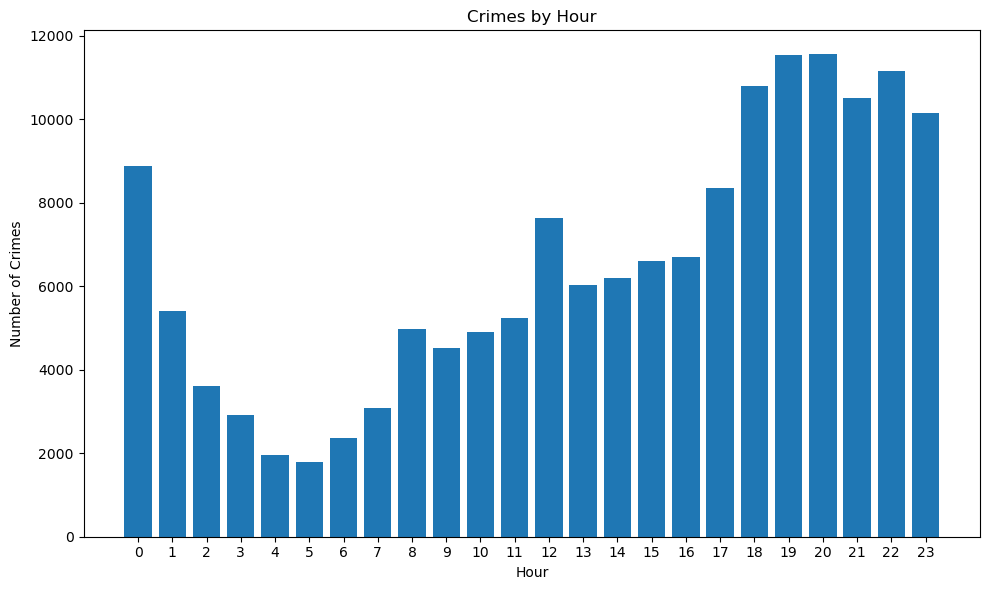

In [12]:
plot_crime_hours_distribution(gdf_with_time)

It can be observed that more crimes occur in the evening and night time, whereas the least crimes occur in the morning.

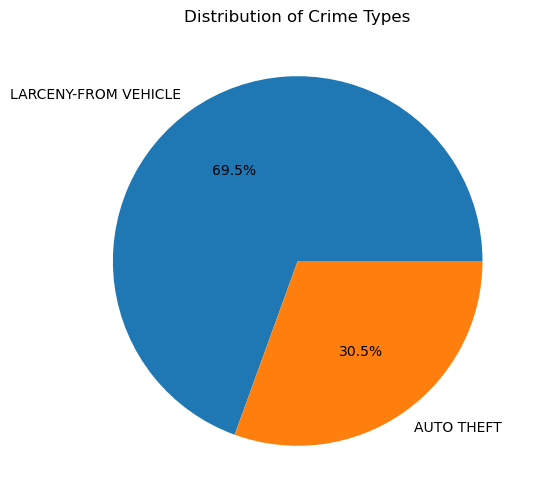

In [13]:
plot_crime_types_pie_chart(original_gdf)

# Studying Correlation between Number of Crimes and Population Density

### Null Hypothesis:
"The population density in a certain area has no correlation with the number of crime counts there."

### Alternative Hypothesis:
"The population density in a certain area has a correlation with the number of crime counts there."

## Yearly Grids Making With Population Density

In [14]:
xmin, ymin, xmax, ymax, cell_size = get_grid_parameters(atl, pops, 2016)
grid_gdfs = generate_yearly_grids_with_population(pops, gdf_with_date, xmin, ymin, xmax, ymax, cell_size)

In [15]:
grid_gdfs[2020].head()

geometry  \
0  POLYGON ((-84.54273 33.69781, -84.54273 33.706...   
1  POLYGON ((-84.53440 33.68947, -84.53440 33.697...   
2  POLYGON ((-84.53440 33.69781, -84.53440 33.706...   
3  POLYGON ((-84.52607 33.65614, -84.52607 33.664...   
4  POLYGON ((-84.52607 33.68114, -84.52607 33.689...   

                     centroid  population_density  index  crime_count  
0  POINT (-84.54690 33.70197)          846.793518      6            4  
1  POINT (-84.53857 33.69364)          676.275208     34            8  
2  POINT (-84.53857 33.70197)          923.069519     35            7  
3  POINT (-84.53023 33.66031)          490.229828     59            2  
4  POINT (-84.53023 33.68531)          590.106445     62            2

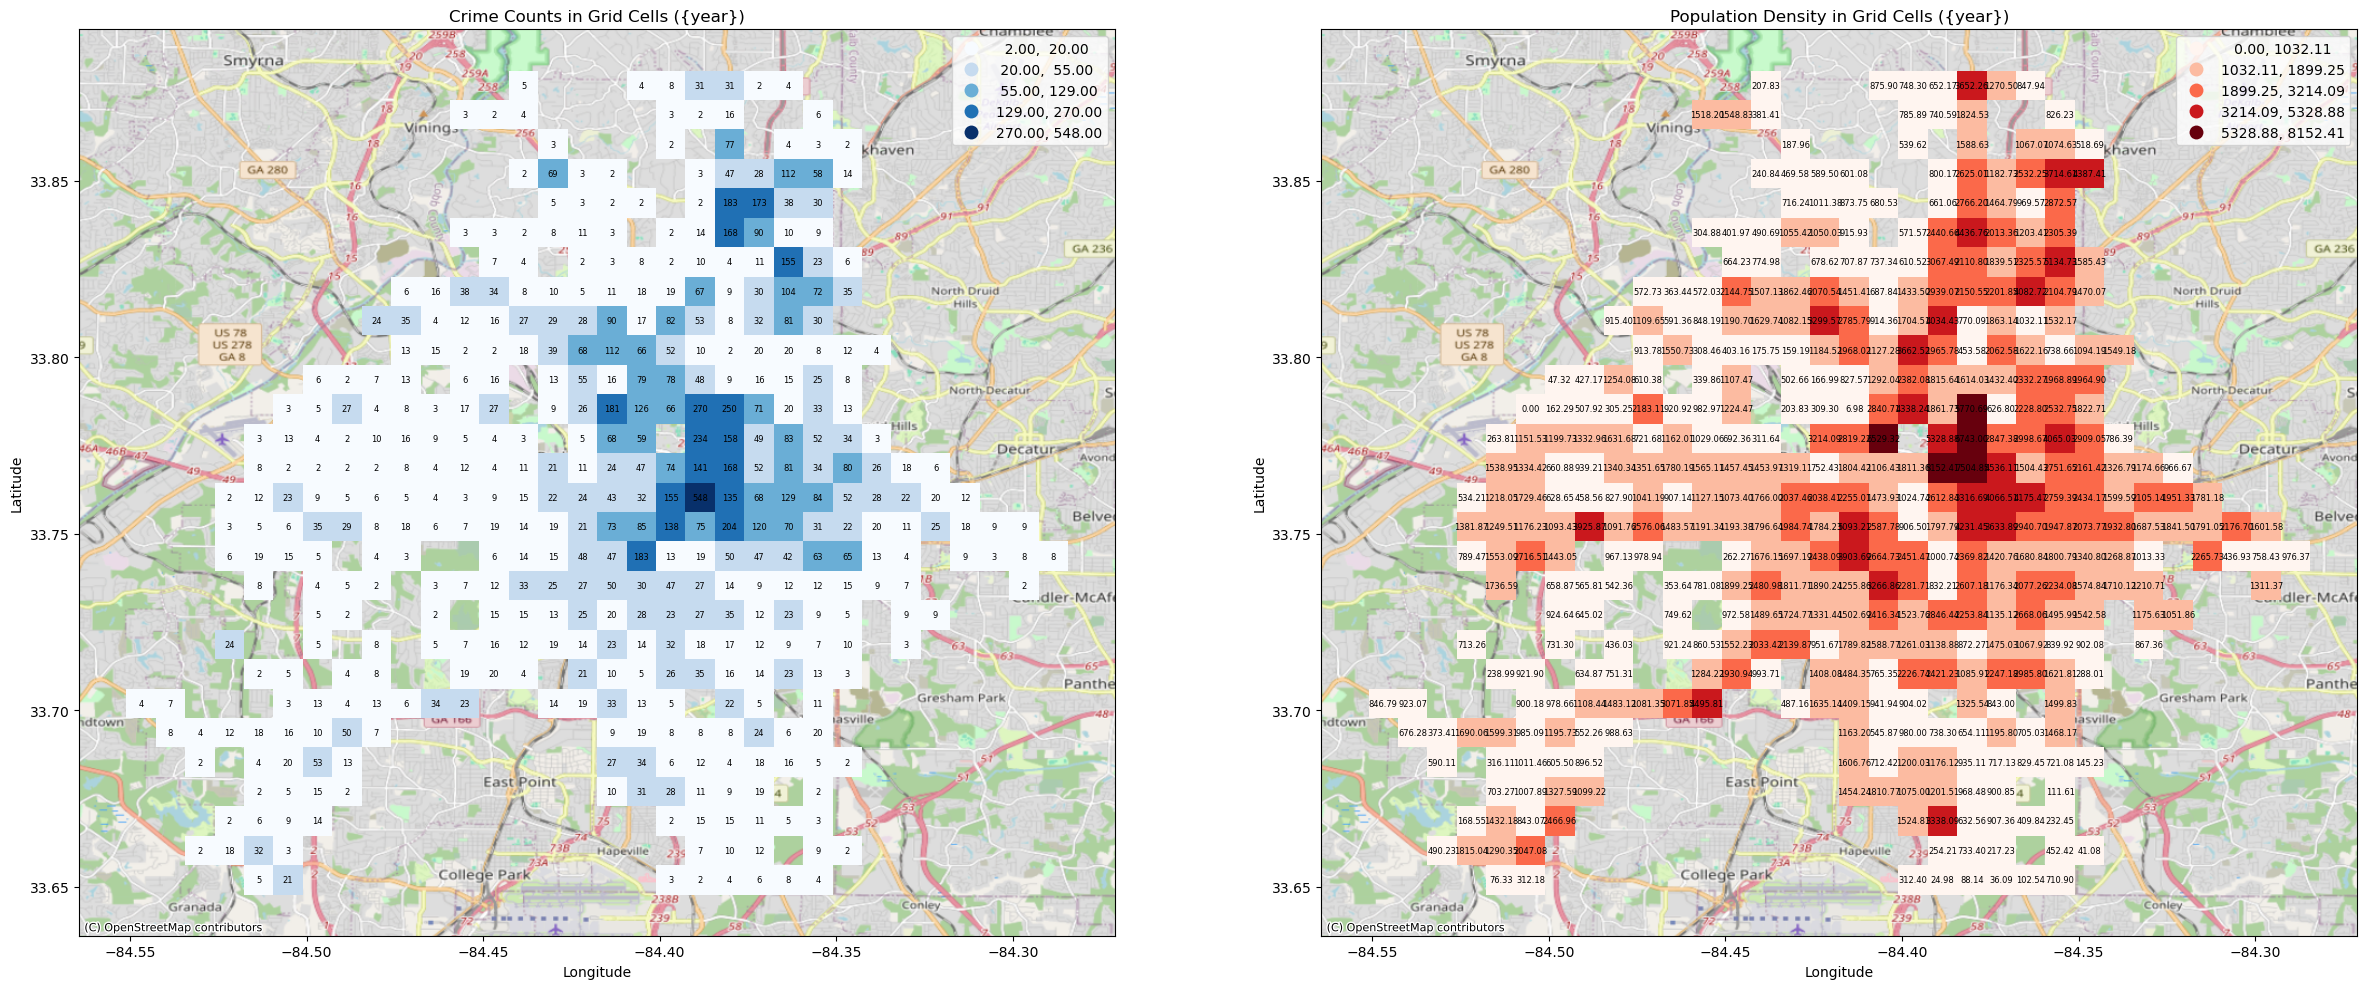

In [16]:
# Plot crime and population density for the year 2020
plot_crime_and_pop_for_year(grid_gdfs, 2020)

## Measuring Correlation Between Population Density and Crime Counts <br> 
- ## Pearson Correlation Coefficient <br>

In [17]:
correlation_results = calculate_correlation_for_each_year(grid_gdfs)

Year: 2016
Pearson correlation coefficient: 0.3294
P-value: 2.1512e-12

Year: 2017
Pearson correlation coefficient: 0.2423
P-value: 3.4212e-07

Year: 2018
Pearson correlation coefficient: 0.0666
P-value: 1.6700e-01

Year: 2019
Pearson correlation coefficient: 0.2151
P-value: 7.6773e-06

Year: 2020
Pearson correlation coefficient: 0.4913
P-value: 1.2553e-27



### Yearly Results:
In 2016 and 2020, there's a statistically significant positive correlation (p-value < 0.05). This suggests that areas with higher population density might have had slightly more crime in those specific years.

The correlation coefficients for 2017-2019 are very weak (close to 0) and not statistically significant (p-value > 0.05). This means there's no clear evidence of a relationship between population density and crime rates in those years.

In [18]:
combined_correlation, combined_p_value = calculate_combined_correlation(grid_gdfs)

Pearson correlation coefficient (all years): 0.2799
P-value (all years): 1.5004e-41


### Overall Results:

Based on the overall results, we statistically conclude that there's a significant association between crime counts and population density across the years analyzed altogether, with a p-value of 3.6009e-12. However, the correlation is weak, with a coefficient of 0.1472. This suggests that while there's a relationship between these variables, it's not strong enough to make any definitive conclusions.

## <br>
- ## Spatial Regression <br>

In [19]:
regression_results = perform_linear_regression_yearly(grid_gdfs)

Year: 2016
                            OLS Regression Results                            
Dep. Variable:            crime_count   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     52.35
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           2.15e-12
Time:                        14:49:34   Log-Likelihood:                -2134.6
No. Observations:                 432   AIC:                             4273.
Df Residuals:                     430   BIC:                             4281.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 15.

### Yearly Analysis:
Population density appears to have a varying but generally positive association with crime count over the years, with the relationship being more pronounced and statistically significant in 2016 and 2020.

In [20]:
regression_results_summary = perform_combined_linear_regression(grid_gdfs)

Regression results for all years combined:
                            OLS Regression Results                            
Dep. Variable:            crime_count   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     164.8
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           2.11e-36
Time:                        14:49:35   Log-Likelihood:                -10987.
No. Observations:                2153   AIC:                         2.198e+04
Df Residuals:                    2151   BIC:                         2.199e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

### Overall Result:
Based on the regression analysis, population density has a statistically significant but weak positive association with crime counts across all years combined. However, the low R-squared and potential multicollinearity indicate that other factors likely play a more significant role in determining crime counts.

## Final Conclusion:
While there's a statistically significant association between population density and crime counts, the relationship is weak and likely influenced by other factors. However, the results suggest that areas with higher population density might experience slightly more crime, especially in certain years, therefore we reject the null hypothesis.

Also ,further research is needed to understand the complex interplay between population density and crime rates better.

# Identifying Hotspots

In [21]:
crime_gdf

geometry
1       POINT (-84.38777 33.77476)
2       POINT (-84.36694 33.81989)
3       POINT (-84.37651 33.83793)
6       POINT (-84.39019 33.77984)
7       POINT (-84.39323 33.81339)
...                            ...
366783  POINT (-84.31244 33.74403)
366784  POINT (-84.42729 33.75193)
366785  POINT (-84.44454 33.76737)
366786  POINT (-84.40814 33.70546)
366787  POINT (-84.41018 33.70080)

[164263 rows x 1 columns]

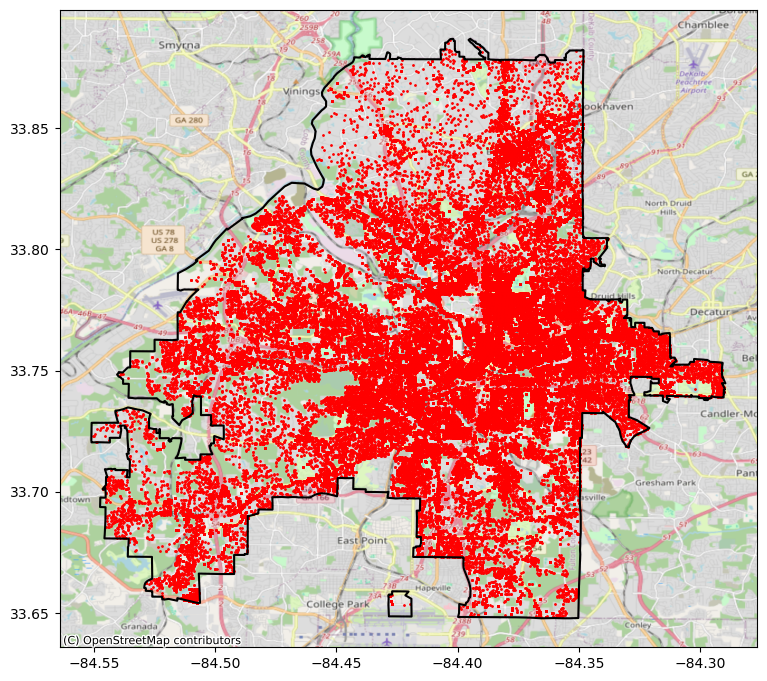

In [22]:
plot_crime_and_boundary(crime_gdf, atl)

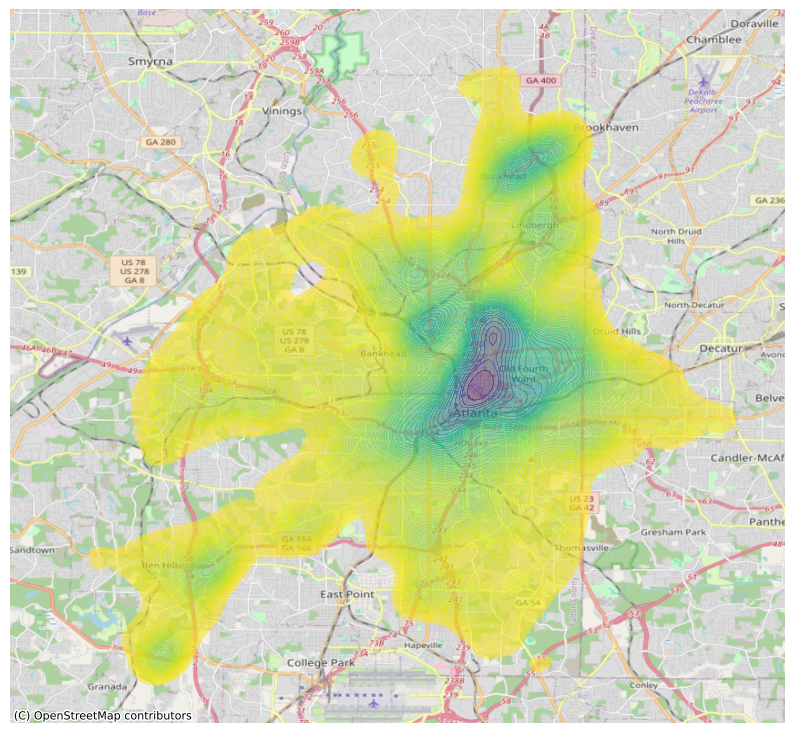

In [23]:
plot_kde_with_basemap(crime_gdf)

## Creating Grids for Overall Crime Counts

In [24]:
xmin, ymin, xmax, ymax, cell_size = get_grid_parameters(atl, pops, 2016)
grid_gdf = create_grid_and_count_crimes(crime_gdf, xmin, ymin, xmax, ymax, cell_size)
grid_gdf

geometry  index  crime_count
0    POLYGON ((-84.54273 33.68114, -84.54273 33.689...      4           10
1    POLYGON ((-84.54273 33.68947, -84.54273 33.697...      5            9
2    POLYGON ((-84.54273 33.69781, -84.54273 33.706...      6           47
3    POLYGON ((-84.54273 33.70614, -84.54273 33.714...      7            2
4    POLYGON ((-84.54273 33.71447, -84.54273 33.722...      8            3
..                                                 ...    ...          ...
537  POLYGON ((-84.29273 33.73947, -84.29273 33.747...    881          109
538  POLYGON ((-84.29273 33.74781, -84.29273 33.756...    882          142
539  POLYGON ((-84.28440 33.73114, -84.28440 33.739...    909            9
540  POLYGON ((-84.28440 33.73947, -84.28440 33.747...    910          121
541  POLYGON ((-84.28440 33.74781, -84.28440 33.756...    911           27

[542 rows x 3 columns]

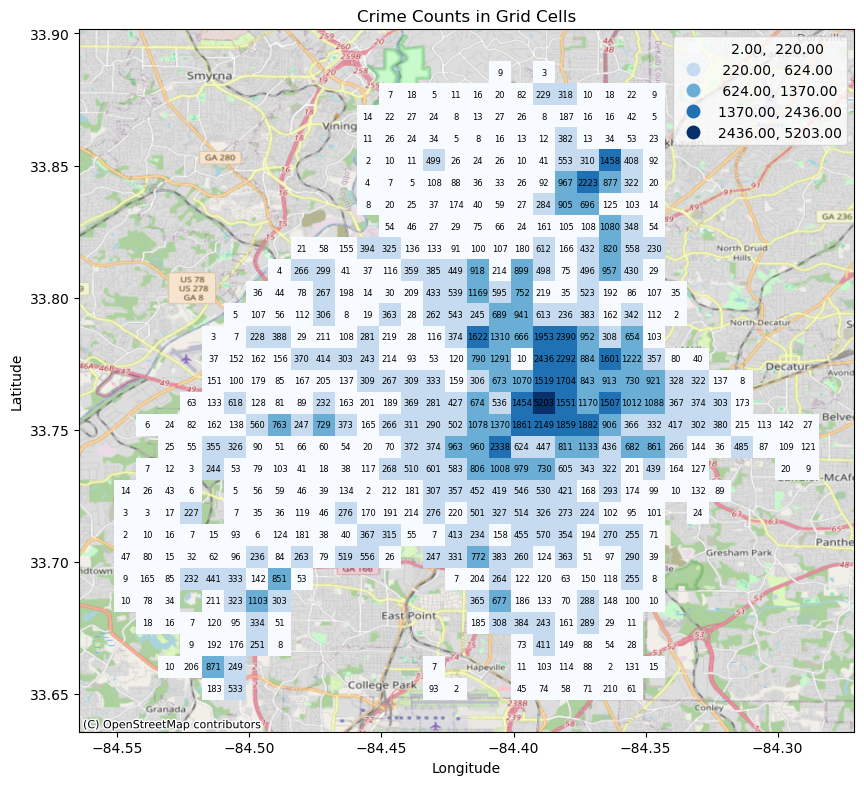

In [25]:
plot_crime_counts(grid_gdf)

## Spatial Autocorrelation Analysis

In [26]:
# Create a spatial weights matrix
w = weights.Queen.from_dataframe(grid_gdf)
moran = compute_morans_i(grid_gdf,w)
print("Moran's I:", moran.I)

Moran's I: 0.5779106708046335


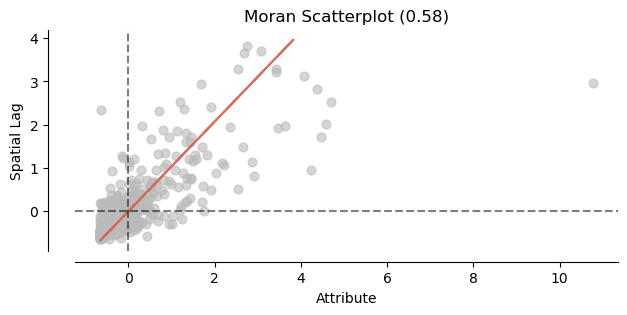

In [27]:
moran_scatterplot(moran, aspect_equal=True)
plt.show()

### Analysis:
A Global Moran's I value of 0.5779106708046335 suggests a moderate to strong positive spatial autocorrelation. This means that, on average, similar values are clustered together in the spatial distribution. In other words, neighboring regions exhibit similar crime counts, which could imply localized patterns or spatial dependencies in crime occurrences.

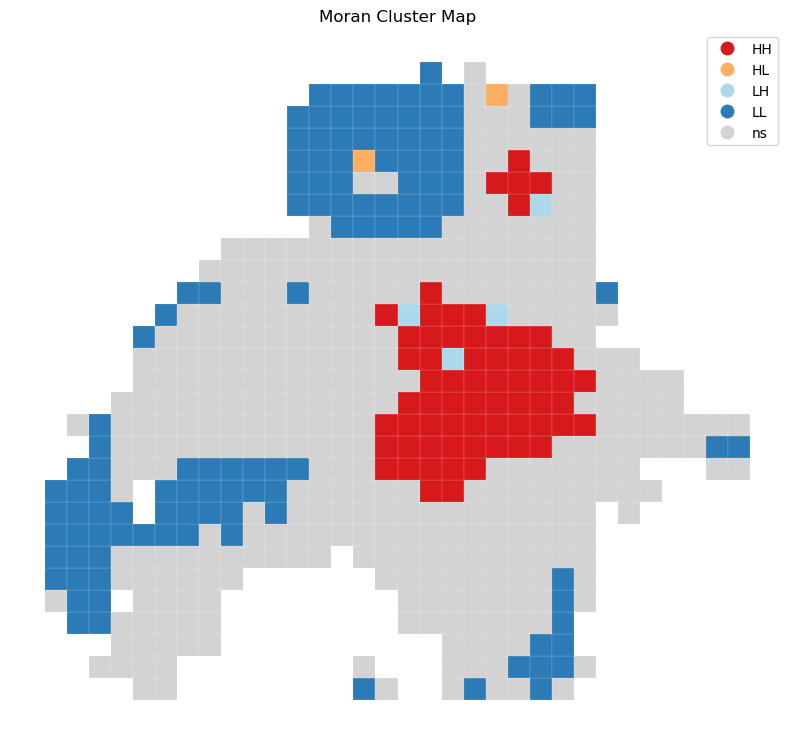

In [28]:
plot_local_morans_i(grid_gdf,w)

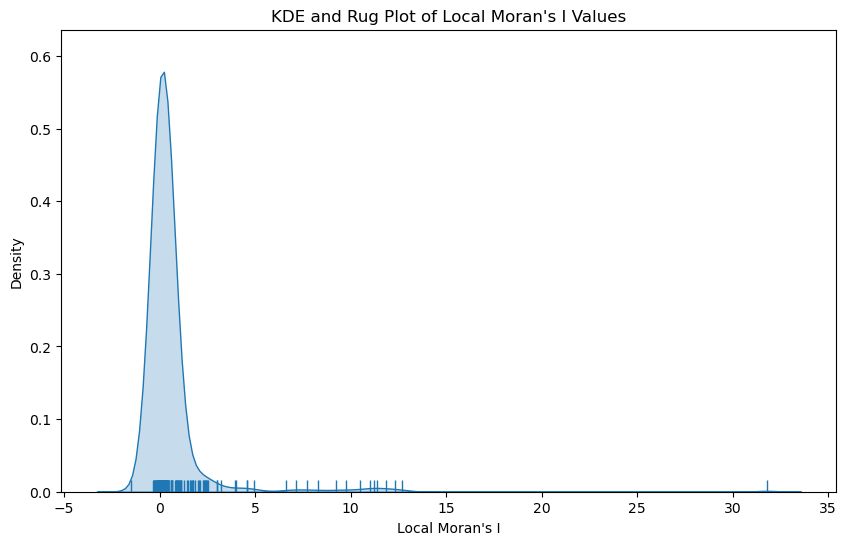

In [29]:
local_moran = esda.moran.Moran_Local(grid_gdf['crime_count'], w)
plot_local_morans_i_kde(local_moran)

### Interpretation <br>
 - The sharp peak near zero suggests that for most locations, the local spatial autocorrelation (as measured by Moran's I) is weak or negligible.<br>
<br>
- The long tail to the right indicates that there are a few locations with high positive spatial autocorrelation, meaning those locations are part of clusters with similar values. <br>

# Safest Route Finder Algorithm

In [30]:
# Example usage
coords1 = (-84.390000, 33.860000)
coords2 = (-84.412000, 33.755000)


safest_route, safety_score = calculate_safest_route(coords1, coords2, gdf_with_time, num_alternatives=3)
if safest_route:
    visualize_safest_route(safest_route, safety_score)

else:
    print("No routes found. Check your API key or consider trying a different location.")
        
        


Current date and time: 14:52
Looking for all crimes that occurred between 14:22 and 15:22
Found 149 intersecting crimes for route 1.
Found 123 intersecting crimes for route 2.
Found 126 intersecting crimes for route 3.
Choosing route with safety score: 123
